<a href="https://colab.research.google.com/github/karma-os/Kaggle_study/blob/main/MySpooky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **My own way to do Spooky**

# **_Data, Module Setup__**

In [1]:
"""
Module Setup
"""

#Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#Import sklearn and its subfunction

from sklearn import ensemble, naive_bayes, svm, pipeline, preprocessing, metrics, model_selection, decomposition
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import log_loss, multilabel_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Import NLP libraries
import nltk
nltk.download("punkt")
nltk.download("stopwords")

from wordcloud import WordCloud, STOPWORDS

#Other libraries
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from nltk import word_tokenize
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

In [3]:
## For plotly issue
"""
Check if plotly is installed
Check if plotly version < 4.
Check if the environment is notebook, or whatever.
"""

import plotly.io as pio

def set_default_plotly(DEFAULT = "notebook_connected"):
    pio.renderers.default = DEFAULT
set_default_plotly("colab")

In [4]:
import os

In [7]:
#Dataset Load
INITIAL_RUN = True
CHANGE_DIR = "/content/drive/MyDrive/Kaggle_kernel/data"
if INITIAL_RUN:
    os.chdir(CHANGE_DIR)
    !mkdir -p -f /root/.kaggle
    !cp /content/drive/MyDrive/Kaggle/kaggle.json  /root/.kaggle/kaggle.json   # kaggl.json위치 지정
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle competitions download -c spooky-author-identification
    INITIAL_RUN= False

mkdir: invalid option -- 'f'
Try 'mkdir --help' for more information.
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [8]:
#Data Setup
FLAG = True
if FLAG : 
    !unzip -f train.zip
    !unzip -f test.zip

Archive:  train.zip
Archive:  test.zip


In [9]:
INSTALLED = True
if not INSTALLED:
    !pip install imageio
    !pip install wordcloud
    !pip install plotly

    #Plotly & Jupyter notebook 연동
    !pip install notebook>=5.3
    !pip install ipywidgets>=7.5
    !pip install nltk
    !pip install chart_studio
    !pip install cufflinks
    INSTALLED = True

# **_EDA_**
어떻게 생겨먹었는지부터 보자.


## Basic Play

In [10]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [11]:
#Train has shape 19579 x 3
train.shape
print("columns:",train.columns)

columns: Index(['id', 'text', 'author'], dtype='object')


In [12]:
import plotly.graph_objects as go


In [13]:
author_dict = {"EAP":"Edgar Allan Poe" , "MWS" : "Mary Shelley", "HPL" : "HP Lovecraft"}

In [14]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(title='Author and Text Number')

fig = go.Figure(data = data, layout = layout)
fig.show()

In [15]:
all_words = train.text.str.split(expand = True).unstack().value_counts()
data = [go.Bar(
    x = all_words.index.values[2:50],
    y = all_words.values[2:50],
    marker = dict(colorscale = "Jet", 
                  color = all_words.values[2:100]),
    text = "Word Counts"
)]
layout = go.Layout(title = "Top 50(Uncleaned) Word Freqs in the training dataset")
fig = go.Figure(data = data, layout = layout)
fig.show()


## Some observations
-Of course, many needless words ;-(.
-Word clensing for stopwords is necessary!

## WordCloud !

In [16]:
from imageio import imread
import codecs
import base64

In [17]:
#Img encoding & Decoding code
def encode_img(fname):
    with open(fname,"rb") as img:
        tmp = base64.b64encode(img.read())
    return tmp 

def decode_new_img(fname):
    tmp = encode_img(fname)
    f1 = open(fname,"wb")
    f1.write(codecs.decode(tmp, "base64"))
    f1.close()
    img = imread(fname)
    return img

In [18]:
hcmask1 = decode_new_img("eap.png")
hcmask2 = decode_new_img("mws.png")
hcmask3 = decode_new_img("hpl.png")

In [19]:
eap = train[train.author == "EAP"]["text"].values
hpl = train[train.author == "HPL"]["text"].values
mws = train[train.author == "MWS"]["text"].values

In [20]:
print(encode_img("eap.png") == encode_img("mws.png"))
print(encode_img("hpl.png") == encode_img("mws.png"))

False
False


(-0.5, 511.5, 511.5, -0.5)

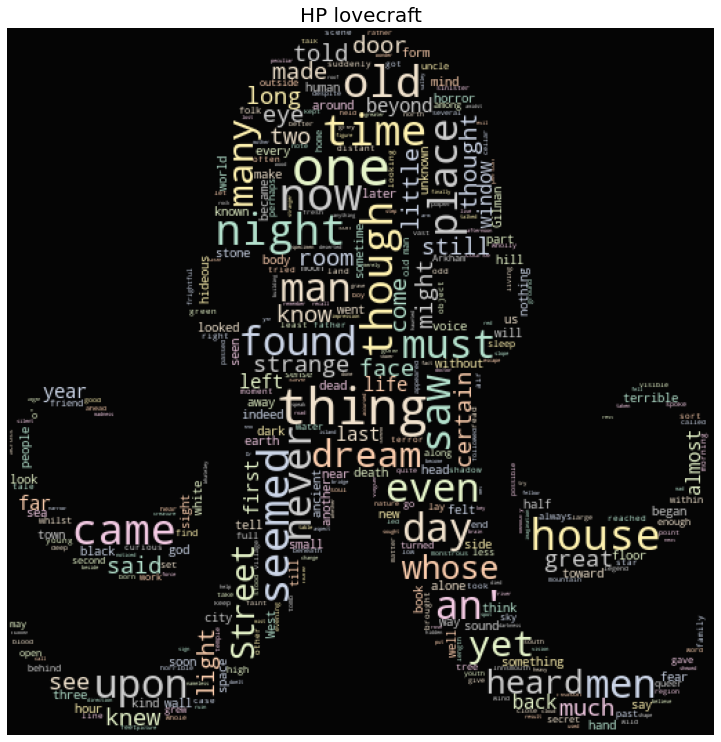

In [21]:
plt.figure(figsize = (16,13))
wc = WordCloud(background_color="black", max_words = 10000,
               mask = hcmask3, stopwords = STOPWORDS, max_font_size = 40)
wc.generate(" ".join(hpl))
plt.title("HP lovecraft", fontsize = 20)
plt.imshow(wc.recolor(colormap = "Pastel2", random_state = 17), alpha = 0.98)

plt.axis("off")

(-0.5, 639.5, 390.5, -0.5)

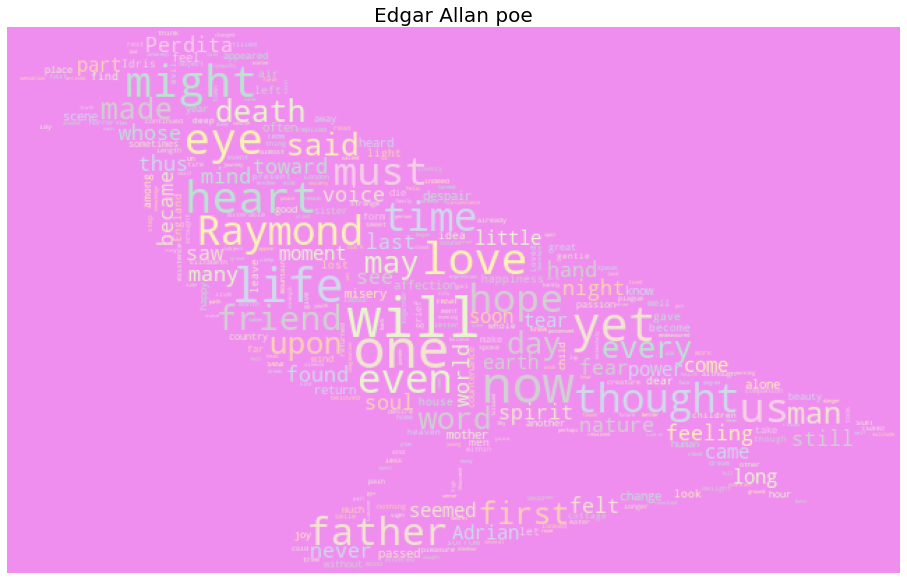

In [22]:
plt.figure(figsize = (16,13))
wc2 = WordCloud(background_color="violet", max_words = 10000,
               mask = hcmask1, stopwords = STOPWORDS, max_font_size = 40)
wc2.generate(" ".join(mws))
plt.title("Edgar Allan poe", fontsize = 20)
plt.imshow(wc2.recolor(colormap = "Pastel2", random_state = 17), alpha = 0.9)
plt.axis("off")

(-0.5, 639.5, 589.5, -0.5)

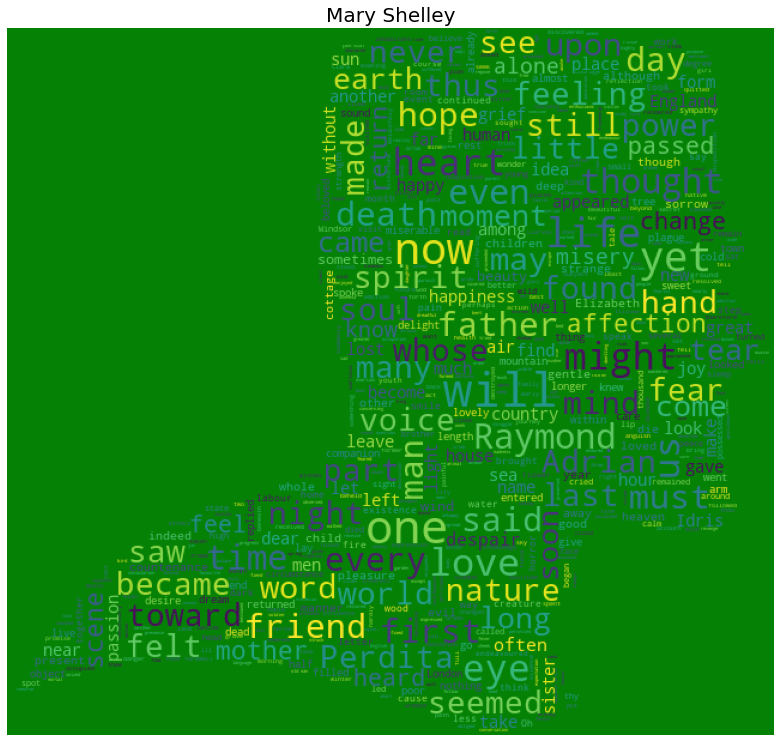

In [23]:
plt.figure(figsize = (16,13))
wc3 = WordCloud(background_color="green", max_words = 10000,
               mask = hcmask2, stopwords = STOPWORDS, max_font_size = 40)
wc3.generate(" ".join(mws))
plt.title("Mary Shelley", fontsize = 20)
plt.imshow(wc3.recolor(colormap = "viridis", random_state = 17), alpha = 0.98)
plt.axis("off")

## NLP start

## <font color = "blue"> **Basic Model** </font>

In [24]:
#Metrics Definition

def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [25]:
#Usually id does not help.
#Author to label at all.

In [26]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author)

In [27]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)


* Let's make features with TFIDF, CountVec

In [28]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')


# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [29]:
#Linear Model : add features to tfv
tfv.fit(list(xtrain)+list(xvalid))
ctv.fit(list(xtrain)+list(xvalid))
xtrain_tfv = tfv.transform(xtrain) ; xvalid_tfv = tfv.transform(xvalid)
xtrain_ctv = ctv.transform(xtrain) ; xvalid_ctv = ctv.transform(xvalid)

## Hey why not try many models?

- (1) SVC  : SVC

- (2) Naive Bayes : MultinomialNB

- (3) Linear_model : LogisticRegression

- (4) DecisionTree : DecisionTreeClassifier 

- (5) Ensemble : Voting, Bagging, boosting, Random_forest

- (6) XGB : XGboost + Grid_search

- (7) LightGBM



In [30]:
MODEL_DICT = {}

In [31]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score

In [32]:
#Linear Model first

lr_ctv = LogisticRegression(C = 1, max_iter = 1000)
dt_ctv = DecisionTreeClassifier()
nb_ctv = MultinomialNB()

lr_tfv = LogisticRegression(C = 1, max_iter = 1000)
dt_tfv = DecisionTreeClassifier()
nb_tfv = MultinomialNB()

In [33]:
def test_model(estimator, word_feature, scaling = False, train_x =xtrain_ctv   ,train_y =ytrain , valid_x = xvalid_ctv,  valid_y = yvalid) :
    model_name = estimator.__class__.__name__

    if word_feature == "tfv":
        train_x = xtrain_tfv
        valid_x = xvalid_tfv
    
    if model_name == "SVC":
        scaling = True
        print("This is the case of SVC")
        svd = decomposition.TruncatedSVD(n_components = 120)
        svd.fit(train_x)
        train_x = svd.transform(train_x)
        valid_x = svd.transform(valid_x)
    if scaling:
        scl = preprocessing.StandardScaler(train_x)
        scl.fit(train_x)
        train_x = scl.transform(train_x)
        valid_x = scl.transform(valid_x)

    estimator.fit(train_x, train_y)
    predictions = estimator.predict_proba(valid_x)
    word_type = "Count vector" if word_feature =="ctv" else "tf-idf vector"
    loss = multiclass_logloss(yvalid, predictions)
    print(f"Loss of {model_name} on {word_type}: {loss}")
    MODEL_DICT[(model_name, word_type)] = loss

    return loss, train_x, train_y, valid_x, valid_y




In [34]:
test_model(lr_ctv, word_feature = "ctv") 
test_model(lr_tfv,  "tfv")
# testmodel_ctv(dt_ctv)
# testmodel_tfv(dt_tfv)
test_model(nb_ctv, "ctv")
test_model(nb_tfv, "tfv")

Loss of LogisticRegression on Count vector: 0.5265576083277469
Loss of LogisticRegression on tf-idf vector: 0.5715595160289009
Loss of MultinomialNB on Count vector: 0.4854149231348956
Loss of MultinomialNB on tf-idf vector: 0.5778049688756708


(0.5778049688756708,
 <17621x15102 sparse matrix of type '<class 'numpy.float64'>'
 	with 198521 stored elements in Compressed Sparse Row format>,
 array([2, 0, 2, ..., 0, 2, 2]),
 <1958x15102 sparse matrix of type '<class 'numpy.float64'>'
 	with 22260 stored elements in Compressed Sparse Row format>,
 array([0, 0, 0, ..., 2, 2, 1]))

In [35]:
#Apply svd for applying SVC
svm_ctv = SVC(C=1.0, probability = True)
svm_tfv = SVC(C=1.0, probability = True)
_, xtrain_ctv_svd_scl, _, xvalid_ctv_svd_scl, _ = test_model(svm_ctv, "ctv")
_, xtrain_tfv_svd_scl, _, xvalid_tfv_svd_scl, _ = test_model(svm_tfv, "tfv")

This is the case of SVC


ValueError: ignored

In [36]:
# XGB
xgb_ctv = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_ctv.fit(xtrain_ctv.tocsc(), ytrain)
predictions = xgb_ctv.predict_proba(xvalid_ctv.tocsc())
loss = multiclass_logloss(yvalid, predictions)
MODEL_DICT[("xgboost","ctv")] = loss


KeyboardInterrupt: ignored

In [ ]:
xgb_tfv = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb_tfv.fit(xtrain_tfv.tocsc(), ytrain)
predictions = xgb_tfv.predict_proba(xvalid_tfv.tocsc())
loss = multiclass_logloss(yvalid, predictions)
MODEL_DICT[("xgboost","ctv")] = loss

In [ ]:
MODEL_DICT

In [ ]:
"""
GPU 설정할 수 있는지 확인!


import xgboost as xgb 
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

param = {
    'max_depth': 4,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1, # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2, # the number of classes that exist in this datset
#   'gpu_id': 0, # 특정 GPU를 지정하고 싶을때 쓰는 id 
    'n_gpus' : 2, # 2개 사용하자
    'max_bin': 16, # GPU 
    'tree_method': 'gpu_hist', # GPU method (자세한 설명은 문서로!)
    'predictor':'gpu_predictor' # train뿐만아니라 predict할때도 gpu쓸건지 결정
}   

num_round = 35 # the number of training iterations
model = xgb.train(param, dtrain, num_round)

"""

# <font color = "blue"> Deep Learning Section </font>

In [37]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM, SimpleRNN
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.layers import GlobalMaxPool1D, Conv1D, MaxPool1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.utils import to_categorical

In [38]:
# GLOVE_EXIST = False

In [39]:
if not GLOVE_EXIST:
    !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
    !unzip glove.840B.300d.zip
    GLOVE_EXIST = True

NameError: ignored

In [40]:
#Word Vector Embedding
embeddings_index = {}
f = open('glove.840B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    try :
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        f.__next__()
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2195997it [02:55, 12493.84it/s]

Found 2195864 word vectors.


In [41]:
#Normalized vector of whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try: 
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis = 0)
    if type(v)!=np.array:
        return np.zeros(300)
    return v/np.sqrt((v**2).sum())



In [42]:
#Create sentence ves using above ftn for train, val

xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 1958/1958 [00:00<00:00, 2935.96it/s]


#Before feeding to the DL model, we scale it












In [43]:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [44]:
ytrain_enc = to_categorical(ytrain)
yvalid_enc = to_categorical(yvalid)

### Simple NN

In [45]:
input_tensor = Input(shape = (300,), name = "input")
x = Dense(300, activation = "relu", name = "dense1")(input_tensor)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

x = Dense(300,activation = "relu", name = "dense2")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(3)(x)
output = Activation("softmax")(x)
model = Model(inputs= input_tensor, outputs = output)

model.summary()
model.compile(loss="categorical_crossentropy",optimizer = "adam")

#model fitting
history = model.fit(xtrain_glove_scl, y = ytrain_enc, batch_size = 64,
          epochs = 5, verbose = 1,
          validation_data=(xvalid_glove_scl, yvalid_enc))

loss = history.history['val_loss']
last_loss = loss[-1]
last_loss
MODEL_DICT[("NN","Glove")] = loss

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense2 (Dense)               (None, 300)               90300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200  

~~~
It seems simple NN is not enough, isn't it?
~~~

<font color = "red"> It's val_loss is 1.0877!! </font>

## Before feeding to RNN / LSTM ..

In [46]:
# To move further, we do using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [47]:
#Create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 25943/25943 [00:00<00:00, 367525.23it/s]


#Simple RNN

In [48]:
input_tensor = Input(shape = (max_len,))
x = Embedding(len(word_index)+1,300, input_length = max_len)(input_tensor)
x = SimpleRNN(100)(x)
output = Dense(3, activation = "softmax")(x)
model = Model(inputs = input_tensor, outputs = output)

earlystop = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 3, verbose = 0, mode = "auto")

model.compile(loss = "categorical_crossentropy", optimizer = "adam")
history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=5, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc),          
          callbacks = [earlystop]           )

loss = history.history['val_loss']
last_loss = loss[-1]
last_loss
MODEL_DICT[("RNN","Glove")] = loss

Epoch 1/5
35/35 [==============================] - 4s 81ms/step - loss: 0.9955 - val_loss: 0.8351
Epoch 2/5
35/35 [==============================] - 3s 73ms/step - loss: 0.4609 - val_loss: 0.5233
Epoch 3/5
35/35 [==============================] - 3s 81ms/step - loss: 0.1464 - val_loss: 0.4541
Epoch 4/5
35/35 [==============================] - 3s 77ms/step - loss: 0.0524 - val_loss: 0.4948
Epoch 5/5
35/35 [==============================] - 3s 78ms/step - loss: 0.0224 - val_loss: 0.5174


## LSTM

In [49]:
input_layer = Input(shape = (max_len,))
embedding = Embedding(len(word_index)+1, 300, weights = [embedding_matrix], 
              input_length = max_len, trainable = False)(input_layer)
x = SpatialDropout1D(0.3)(embedding)
x = LSTM(100, dropout = 0.3, recurrent_dropout = 0.3)(x)

x = Dense(1024, activation = "relu")(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation = "relu")(x)
x = Dropout(0.8)(x)

x = Dense(3)(x)
output = Activation("softmax")(x)

model = Model(inputs = input_layer, outputs = output)

#Fit the model with early stopping callback

earlystop = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 3, verbose = 0, mode = "auto")

model.compile(loss = "categorical_crossentropy", optimizer = "adam")


model.summary()

history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc),          
          callbacks = [earlystop]           )

loss = history.history['val_loss']
last_loss = loss[-1]
last_loss
MODEL_DICT[("LSTM","Glove")] = loss





Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 300)           7783200   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 70, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049

# Bidirectional LSTM

In [50]:
input_layer = Input(shape = (max_len,))
embedding = Embedding(  
    len(word_index)+1, 300, weights = [embedding_matrix],
    input_length = max_len,trainable = False
    )(input_layer) 
x = SpatialDropout1D(0.3)(embedding)
x = Bidirectional(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))(x)

x = Dense(1024, activation = "relu")(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation = "relu")(x)
x = Dropout(0.8)(x)

output = Dense(3, activation = "softmax")(x)

model = Model(inputs = input_layer, outputs = output)

#Fit the model with early stopping callback

earlystop = EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 3, verbose = 0, mode = "auto")

model.compile(loss = "categorical_crossentropy", optimizer = "adam")

model.summary()

history = model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc),          
          callbacks = [earlystop]           )

loss = history.history['val_loss']
last_loss = loss[-1]
last_loss
MODEL_DICT[("Bi-LSTM","Glove")] = loss






Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 300)           7783200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 300)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              615424    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049

In [54]:
for key in MODEL_DICT.keys():
    value = MODEL_DICT[key]
    if type(value)==list:
        MODEL_DICT[key] = value[-1]

In [71]:
test

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...
...,...,...
8387,id11749,All this is now the fitter for my purpose.
8388,id10526,I fixed myself on a wide solitude.
8389,id13477,It is easily understood that what might improv...
8390,id13761,"Be this as it may, I now began to feel the ins..."


In [72]:
xtest = test["text"]

In [73]:
# To move further, we do using keras tokenizer here
token.fit_on_texts
xtest_seq = token.texts_to_sequences(xtest)

# zero pad the sequences
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

In [77]:
result = model.predict(xtest_pad)